# Control Tutorial_6
_Reference : The Control Handbook, Control System Fundamentals, Edited by William S.Levine from p9-88 to p9-89_, http://apmonitor.com/pdc/index.php/Main/FeedforwardControl

# Feedforward control
---
Disturbances can be eliminated by feedback. Feedforward control is a strategy to reject persistent disturbances that cannot adequately be rejected with feedback control. Feedforward control is typically added to feedback control and is not usually implemented alone. In certain situations, the performance of control systems can be enhanced greatly by the application of feedforward control. Feedforward can be used for both linear and nonlinear systems.

Two key characteristics are needed:
1. An identifiable disturbance is affecting significantly the measured variable, in spite of the attempts of a feedback control system to regulate these effects
2. This disturbance can be measured, perhaps with the addition of instrumentation

## The Control law
<img src="figures/feedforward.png" hight="170">
As an illustration we consider a linear system that has two input, the control signal $u(t)$ and the disturbance $d(t)$, and one output $y(t)$.   
The transfer function from disturbance to output is $G_D(s)$, and the transfer function of the plant is $G_P(s)$.  
The process can be described by  

$$
Y(s) = G_P(s)U(s) + G_D(s)D(s)
$$

Where, the Laplace transformed variables are denoted by capital letters.  
The ideal feedforward controller makes the output zero for all disturbances $d(t)$. Thus, the feedforward transfer function shoul be chosen as

$$
G_{ff}(s) = -\frac{G_D(s)}{G_P(s)}
$$

# Simulation (Using transfer function)
The "Sympy" module is useful for the calculation of the transfer function.

In [1]:
from scipy import signal
from scipy import misc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import sympy as sy
s,t = sy.symbols('s t') # Declaration of the variables

In [2]:
def lti_to_sympy(lsys, symplify=True):
    """ Convert Scipy's LTI instance to Sympy expression """
    s = sy.Symbol('s')
    G = sy.Poly(lsys.num, s) / sy.Poly(lsys.den, s)
    return sy.simplify(G) if symplify else G

def sympy_to_lti(xpr, s=sy.Symbol('s')):
    """ Convert Sympy transfer function polynomial to Scipy LTI """
    num, den = sy.simplify(xpr).as_numer_denom()  # expressions
    p_num_den = sy.poly(num, s), sy.poly(den, s)  # polynomials
    c_num_den = [sy.expand(p).all_coeffs() for p in p_num_den]  # coefficients
    l_num, l_den = [sy.lambdify((), c)() for c in c_num_den]  # convert to floats
    return signal.lti(l_num, l_den)

## Example (Feedforward + PID controller)

To illustlate Feedforward control, let's consider the FF-PID controller.   
In this example, Consider the additional disturbance input represened by $D(s)$.

#### Plant
---
<img src="figures/MSD_system.png" hight="150">
We consider a simple second order system (Mass-Spring-Damper system) as a plant.  

$$
G_P(s) = \frac{1}{ms^2+cs+k} 
$$

The typical parameters of Mass-Spring-Damper system setup are selected as following:   
Mass of the cart:  $m  = 1$ [kg]   
The spring constant: $k = 1$ [N/m]   
The damping constant: $c = 1$ [N/(m/s)] 


In [3]:
def MSD_plant(m=1,k=1,c=1):
    num = [1/m] 
    den = [1, c/m, k/m] 
    return signal.lti(num, den)

#### PID controller
---
The transfer function of the PID controller has the form like (See [Control Tutorial_5])

$$
C(s) = \frac{U(s)}{E(s)} = K \left( 1 + \frac{1}{T_is} + T_ds \right) = K\frac{T_iT_ds^2+T_is+1}{T_is}
$$

The typical parameters of PID controller are selected as following:   
The system gain:  $K  = 10$    
The integral time constant: $T_i = 1$  
The derivative time constant: $T_d = 1$ 

In [4]:
def PID_controller(K=10,T_i=1,T_d=1):
    num = [K*T_i*T_d, K*T_i, K] 
    den = [T_i, 0] 
    return signal.lti(num, den)

#### Disturbance and Feedforward controller
---
Let $d(t)$ represent the horizontal wind force on the mass.  
$d(t)$ is the force which affects the mass, therefore the transfer function from the disturbance $d(t)$ to output $y(t)$ is thus same as $G_P(s)$

$$
G_D(s) = G_P(s) = \frac{1}{ms^2+cs+k} 
$$

The ideal feedforward controller makes the output zero for all disturbances $d(t)$. Thus, the feedforward transfer function shoul be chosen as $G_{ff}(s) = -\frac{G_D(s)}{G_P(s)}$.  
However, there is in fact dead time of the controller, so we have to take it into account. We set 0.2[s] as a dead time of this feedforward controller, so the transfer function of the controller is represented by:

$$
G_{ff}(s) = -\frac{G_D(s)}{G_P(s)}\cdot e^{-0.2\cdot s}
$$

The Laplace transform of a time delay of $L$ seconds is $e^{-Ls}$.   
This exponential transfer function is approximated by a rational transfer function using Padé approximation like:

$$
e^{-Ls} = \frac{1-\frac{Ls}{2}+\frac{(Ls)^2}{12}}{1+\frac{Ls}{2}+\frac{(Ls)^2}{12}}
$$

In [5]:
def time_delay(L):
    s = sy.symbols('s')
    pade = (1-(L*s/2)+(L*L*s*s/12))/(1+(L*s/2)+(L*L*s*s/12))
    return pade

In [6]:
# Declare transfer functions in Scipy expression
G_P  = MSD_plant() 
G_D  = MSD_plant()
C    = PID_controller()
Delay = time_delay(0.2)

We convert transfer functions in to sympy expression to make it possible to multiply them.

In [7]:
# Convert transfer functions into Sympy expression
G_Ps, G_Ds, Cs= lti_to_sympy(G_P), lti_to_sympy(G_D), lti_to_sympy(C)

# Feedforward controller transfer function
G_ffs = (-G_Ds / G_Ps)*Delay

#### The control law
<img src="figures/FF-PID.png" hight="170">
In this example, there are two inputs $y_{sp}(t)$ and $d(t)$, and one output $y(t)$ because we consider the additional disturbance into the Mass-Spring-Damper system.  
The transfer function of the system is given by
$$
\left( (Y_sp(s)-Y(s))C(s)+G_{ff}D(s)\right) G_P(s) +G_D(s)D(s) = Y(s)
$$

$$
Y(s) = \frac{C(s)G_P(s)}{1+C(s)G_P(s)}Y_{sp}(s) + \frac{G_{ff}(s)G_P(s)+G_D(s)}{1+C(s)G_P(s)}D(s)
$$

We can transform this equation to th matrix form.
$$
Y_{FF+PID}(s)=\begin{bmatrix} \frac{C(s)G_P(s)}{1+C(s)G_P(s)} & \frac{G_{ff}(s)G_P(s)+G_D(s)}{1+C(s)G_P(s)}\end{bmatrix}\begin{bmatrix}Y_{sp}(s)\\ D(s)\end{bmatrix} = \begin{bmatrix}H1_{FF+PID}(s)& H2_{FF+PID}(s)\end{bmatrix}\begin{bmatrix}Y_{sp}(s)\\ D(s)\end{bmatrix}
$$

To compare the result, we consider the transfer function without the feedforward controller $G_{ff}(s)$

$$
Y_{PID}(s)=\begin{bmatrix} \frac{C(s)G_P(s)}{1+C(s)G_P(s)} & \frac{G_D(s)}{1+C(s)G_P(s)}\end{bmatrix}\begin{bmatrix}Y_{sp}(s)\\ D(s)\end{bmatrix} = \begin{bmatrix}H1_{PID}(s)& H2_{PID}(s)\end{bmatrix}\begin{bmatrix}Y_{sp}(s)\\ D(s)\end{bmatrix}
$$

In this example,  
The desired output is a step function like $y_{sp} = 1 (t>0)$  
The initial state $y(0)=0$

In [8]:
H1s_ffpid = sy.simplify(Cs*G_Ps / (1+Cs*G_Ps)).expand()
H2s_ffpid = sy.simplify((G_Ps*G_ffs+G_Ds)/(1+Cs*G_Ps)).expand()
H1s_pid = sy.simplify(Cs*G_Ps / (1+Cs*G_Ps)).expand()
H2s_pid = sy.simplify((G_Ds)/(1+Cs*G_Ps)).expand()

We convert transfer functions $H1$, $H2$ into scipy expression again.

In [9]:
H1_ffpid, H2_ffpid = sympy_to_lti(H1s_ffpid), sympy_to_lti(H2s_ffpid)
H1_pid, H2_pid = sympy_to_lti(H1s_pid), sympy_to_lti(H2s_pid)

We set the time horizon, the set point $y_{sp}$, and the disturbance $d(t)$ in `numpy.ndarray` type.

In [10]:
# Time horizon
trange = np.linspace(0, 20, 200)

# The set point of y
y_sp = np.ones(len(trange))

# The disturbance
d = np.zeros(len(trange))
d[100] = 10

`scipy.signal.lsim` method can simulate output of a continuous-time linear system.

In [11]:
# Simulate the output of the system
tout1, y1_ffpid, x1 = signal.lsim(H1_ffpid, U=y_sp, T=trange)
tout2, y2_ffpid, x2 = signal.lsim(H2_ffpid, U=d, T=trange)
y_ffpid = y1_ffpid + y2_ffpid

tout1, y1_pid, x1 = signal.lsim(H1_pid, U=y_sp, T=trange)
tout2, y2_pid, x2 = signal.lsim(H2_pid, U=d, T=trange)
y_pid = y1_pid + y2_pid

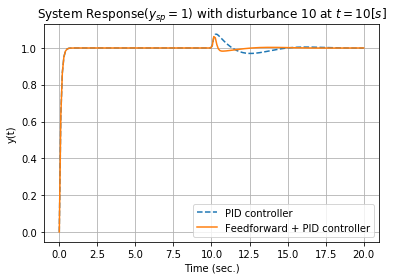

In [12]:
plt.plot(trange, y_pid, "--",label="PID controller")
plt.plot(trange, y_ffpid, label="Feedforward + PID controller")
plt.title('System Response($y_{sp}=1$) with disturbance $10$ at $t=10[s]$')
plt.xlabel('Time (sec.)')
plt.ylabel('y(t)')
plt.grid(True)
plt.legend()
plt.show()

We can see the feedforward controller eliminated the effect of the disturbance at 10[s].